# EX1


## 2 Network Robustness and Phase Transitions
  

For a graph G, p-infinity is the fraction of nodes in the largest connected component.

### 2.1 Robustness in Grids

#### 2.1.1 Two-Dimensional Grids

We will:
1. Build a 100x100 grid.
2. For fractions f=0,0.01,0.02,...,1, remove a random fraction f of nodes.
3. Compute p infinity over multiple trials and plot the robustness curve.


In [1]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
# Function to compute p_infty for a given removal fraction f

def p_infty_grid_2d(n=100, f=0.0, trials=5, seed=None):
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)
    results = []
    for _ in range(trials):
        G = nx.grid_2d_graph(n, n)
        # rename nodes to integers
        G = nx.convert_node_labels_to_integers(G)
        # remove fraction f of nodes
        remove_count = int(f * G.number_of_nodes())
        to_remove = random.sample(list(G.nodes()), remove_count)
        G.remove_nodes_from(to_remove)
        if G.number_of_nodes() == 0:
            results.append(0)
        else:
            largest_cc = max(nx.connected_components(G), key=len)
            results.append(len(largest_cc) / (n*n - remove_count))
    return np.mean(results)


In [ ]:
# Compute robustness curve
fs = np.linspace(0, 1, 101)
p_vals = [p_infty_grid_2d(100, f, trials=10, seed=42) for f in fs]

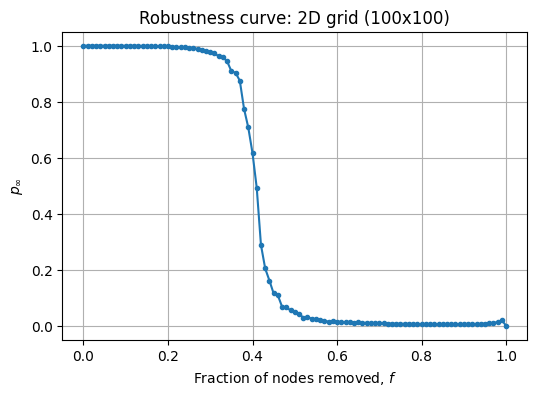

In [ ]:
# Plot
plt.figure(figsize=(6,4))
plt.plot(fs, p_vals, marker='.', linestyle='-')
plt.xlabel('Fraction of nodes removed, $f$')
plt.ylabel('$p_\infty$')
plt.title('Robustness curve: 2D grid (100x100)')
plt.grid(True)
plt.show()

**Observation:** The curve shows that the grid stays almost fully connected untill you remove almost 40% of the nodes, then around the 2D percolation treshold (f=0.43) it abruptly fragments and p-infinity drops to near zero.

**Prediction:** In 3D, connectivity is more robust, so I would predict that the critical removal fraction will be higher.

### Compute for 3D grid


In [3]:
import itertools

In [4]:
def create_grid_3d(n):
    G = nx.Graph()
    for x, y, z in itertools.product(range(n), repeat=3):
        for dx, dy, dz in [(1,0,0),(0,1,0),(0,0,1)]:
            nx.add_path(G, [(x,y,z), (x+dx, y+dy, z+dz)] if x+dx<n and y+dy<n and z+dz<n else [])
    return nx.convert_node_labels_to_integers(G)

In [ ]:
fs3 = np.linspace(0,1,51)
p3_vals = []
for f in fs3:
    vals = []
    for _ in range(5):
        G3 = create_grid_3d(20)
        remove_n = int(f * G3.number_of_nodes())
        to_remove = random.sample(list(G3.nodes()), remove_n)
        G3.remove_nodes_from(to_remove)
        if G3.number_of_nodes()>0:
            cc = max(nx.connected_components(G3), key=len)
            vals.append(len(cc)/(G3.number_of_nodes()))
        else:
            vals.append(0)
    p3_vals.append(np.mean(vals))

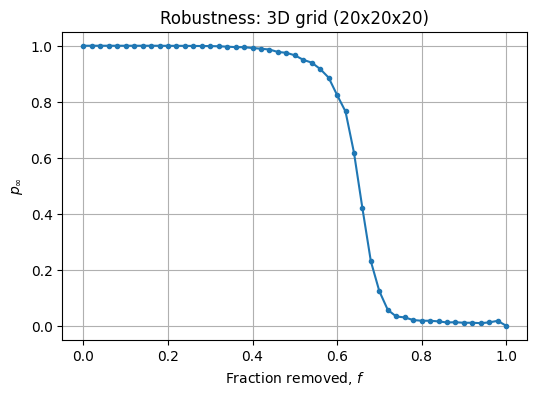

In [ ]:
# Plot
plt.figure(figsize=(6,4))
plt.plot(fs3, p3_vals, marker='.', linestyle='-')
plt.xlabel('Fraction removed, $f$')
plt.ylabel('$p_\infty$')
plt.title('Robustness: 3D grid (20x20x20)')
plt.grid(True)
plt.show()

**Result:** My prediction was correct. In the 3D grid the giant component survives until about 65% of the nodes were removed (compare to about 40 % in 2D case), and only then does p-infinity plunge toward zero, confirming that adding a third dimension makes the lattice markedly more robust to random node loss.


### 2.2 Robustness in Erdős–Rényi Graphs


#### 2.2.1 Random Node Removal


We will generate an ER graph with n=2000 and k=4. Compute its robustness curve.


**Prediction:** Increasing k with the same n means that the graph will be more connected so I would expect that it will shift the drop to the right - higher f values - and lowering k will do exactly the opposite.
Inceasing n will result in larger graph so it with the same k it will probably make the curve sharper and thats because As you scale up n, those fluctuations average out (by the law of large numbers and self-averaging in percolation), so almost every realization loses its giant component at essentially the same fraction making the curve sharper.

In [5]:
from functools import partial

In [6]:
def robustness_ER(n, avg_k, trials, fs, seed):
    np.random.seed(seed)
    random.seed(seed)
    p = avg_k / (n - 1)
    G0 = nx.erdos_renyi_graph(n, p, seed=seed)
    p_inf = []
    for f in fs:
        vals = []
        for _ in range(trials):
            G = G0.copy()
            rem = int(f * n)
            nodes = random.sample(list(G.nodes()), rem)
            G.remove_nodes_from(nodes)
            if G.number_of_nodes() > 0:
                cc = max(nx.connected_components(G), key=len)
                vals.append(len(cc) / (n - rem))
            else:
                vals.append(0)
        p_inf.append(np.mean(vals))
    return p_inf

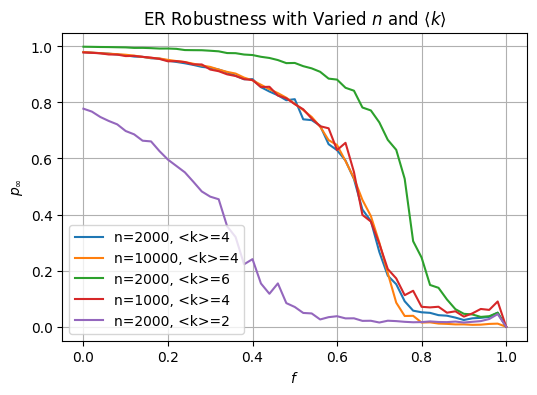

In [ ]:
# cases
fs_er = np.linspace(0, 1, 51)
p_base    = robustness_ER(n=2000, avg_k=4, trials=5, fs=fs_er, seed=42)
p_n_large = robustness_ER(n=10000, avg_k=4, trials=5, fs=fs_er, seed=42)
p_n_lower = robustness_ER(n=1000, avg_k=4, trials=5, fs=fs_er, seed=42)
p_k_high  = robustness_ER(n=2000, avg_k=6, trials=5, fs=fs_er, seed=42)
p_k_lower = robustness_ER(n=2000, avg_k=2, trials=5, fs=fs_er, seed=42)

# plot
plt.figure(figsize=(6, 4))
plt.plot(fs_er, p_base,    label='n=2000, <k>=4')
plt.plot(fs_er, p_n_large, label='n=10000, <k>=4')
plt.plot(fs_er, p_k_high,  label='n=2000, <k>=6')
plt.plot(fs_er, p_n_lower, label='n=1000, <k>=4')
plt.plot(fs_er, p_k_lower, label='n=2000, <k>=2')
plt.xlabel('$f$')
plt.ylabel('$p_\\infty$')
plt.title('ER Robustness with Varied $n$ and $\\langle k\\rangle$')
plt.legend()
plt.grid(True)
plt.show()

The plot shows my prediction was correct and we can see the 2 effects in action:
1. k shifts the collapse point left or right. In k=2 we can see that the graph breaks up almost immidiately. in k=6 we can see that the graphs holds up together until we remove about 70% of its nodes. More links make the network much more resilient to random failures.
2. n seems to control how sharp the drop is. While the 3 curves (n=1000,2000,10000) are close to each other we can still observe that the n=5000 drops a bit sharper than n=2000 and both drops sharper than n=1000.

#### 2.2.2 Adversarial Node Removal


Remove top-degree nodes instead of random and compare.


In [7]:
def adversarial_ER(G0, fs, trials=1):
    n=G0.number_of_nodes()
    curves=[]
    for f in fs:
        G = G0.copy()
        rem=int(f*n)
        # sort by degree
        to_remove=sorted(G.degree(), key=lambda x:x[1], reverse=True)
        nodes=[u for u,_ in to_remove[:rem]]
        G.remove_nodes_from(nodes)
        if G.number_of_nodes()>0:
            cc=max(nx.connected_components(G), key=len)
            curves.append(len(cc)/(n-rem))
        else:
            curves.append(0)
    return curves

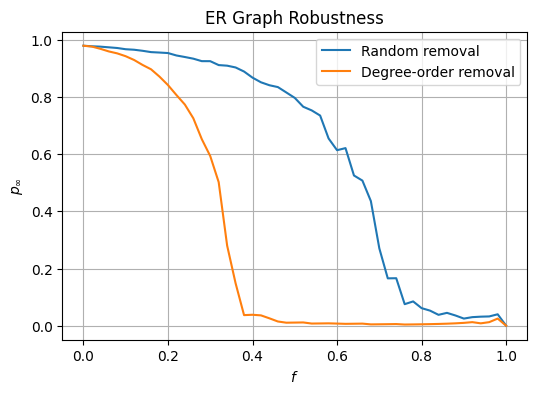

In [ ]:
G0 = nx.erdos_renyi_graph(2000, 4/1999, seed=42)
adv=adversarial_ER(G0, fs_er)
plt.figure(figsize=(6,4))
plt.plot(fs_er, p_er, label='Random removal')
plt.plot(fs_er, adv, label='Degree-order removal')
plt.xlabel('$f$')
plt.ylabel('$p_\infty$')
plt.title('ER Graph Robustness')
plt.legend()
plt.grid(True)
plt.show()

We can clearly see that as we would expect the adversarial curve drops much faster. This phenomana illustrates a vulnerability of the netwok to targeted attacks.

### 2.3 Robustness of Real-World Networks

In [8]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


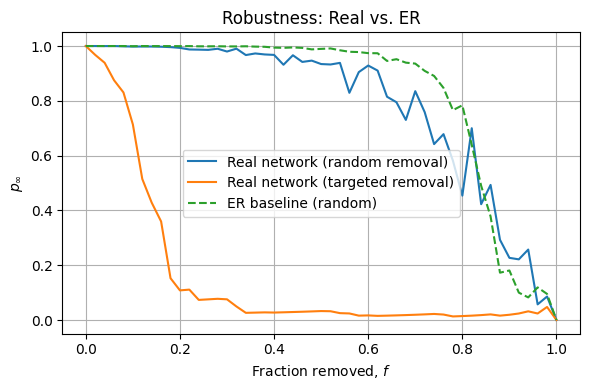

In [9]:
def robustness(G0, fs, trials=5):
    """Random‐removal robustness curve for a graph G0 over fractions fs."""
    n0 = G0.number_of_nodes()
    p_inf = []
    for f in fs:
        vals = []
        for _ in range(trials):
            G = G0.copy()
            rem = int(f * n0)
            nodes = random.sample(list(G.nodes()), rem)
            G.remove_nodes_from(nodes)
            if G.number_of_nodes() > 0:
                cc = max(nx.connected_components(G), key=len)
                vals.append(len(cc) / (n0 - rem))
            else:
                vals.append(0)
        p_inf.append(np.mean(vals))
    return p_inf

def adversarial(G0, fs):
    """Targeted‐removal (highest‐degree first) robustness curve for G0."""
    n0 = G0.number_of_nodes()
    deg_sorted = [u for u,_ in sorted(G0.degree(), key=lambda x: x[1], reverse=True)]
    p_adv = []
    for f in fs:
        G = G0.copy()
        rem = int(f * n0)
        to_remove = deg_sorted[:rem]
        G.remove_nodes_from(to_remove)
        if G.number_of_nodes() > 0:
            cc = max(nx.connected_components(G), key=len)
            p_adv.append(len(cc) / (n0 - rem))
        else:
            p_adv.append(0)
    return p_adv

# --- Load a real‐world network ---
path = '/content/drive/MyDrive/CS/Dynamics, Networks and Computation/ex1/metabolic.edgelist.txt'
G_real  = nx.read_edgelist(path)


# Compute robustness curves
fs = np.linspace(0, 1, 51)
p_real_rand = robustness(G_real, fs, trials=5)
p_real_adv  = adversarial(G_real, fs)

# Baseline ER graph with the same n and average degree
n_real = G_real.number_of_nodes()
avg_k_real = sum(dict(G_real.degree()).values()) / n_real
G_er = nx.erdos_renyi_graph(n_real, avg_k_real / (n_real - 1), seed=42)
p_er_rand = robustness(G_er, fs, trials=5)

# Plotting
plt.figure(figsize=(6, 4))
plt.plot(fs, p_real_rand, label='Real network (random removal)')
plt.plot(fs, p_real_adv,  label='Real network (targeted removal)')
plt.plot(fs, p_er_rand,   label='ER baseline (random)', linestyle='--')
plt.xlabel('Fraction removed, $f$')
plt.ylabel('$p_\\infty$')
plt.title('Robustness: Real vs. ER')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The real "metabolic" network behaves much like its ER twin under random failures—it stays fully connected until we've knocked out roughly 70–80 % of the nodes, and then the giant component collapses—though you see a bit more jitter (because the real graph has uneven community structure and degree heterogeneity).
Under targeted attack, however, it falls apart almost immediately: removing the top ~15–20 % highest‑degree actors shatters the network (orange curve), versus almost no damage under random removal at that same f.
This dramatic gap between random and adversarial removal—far larger than in the ER case—reflects the presence of hubs in the real network whose removal is catastrophically disruptive.

#### 2.3.1 Adversarial Strategies


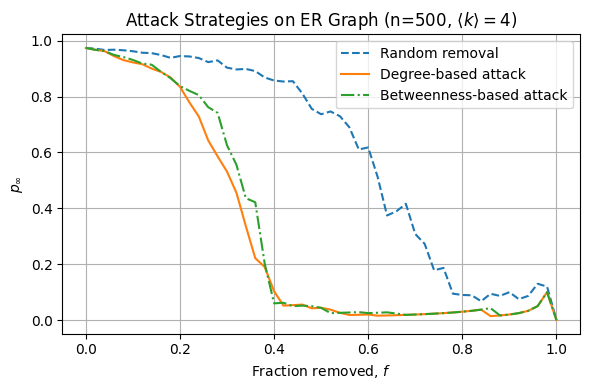

In [ ]:
def adversarial_ER_betweenness(G0, fs):
    n = G0.number_of_nodes()
    # compute betweenness once
    bt = nx.betweenness_centrality(G0)
    ranking = [u for u,_ in sorted(bt.items(), key=lambda x: x[1], reverse=True)]
    p_adv = []
    for f in fs:
        G = G0.copy()
        rem = int(f * n)
        to_remove = ranking[:rem]
        G.remove_nodes_from(to_remove)
        if G.number_of_nodes()>0:
            cc = max(nx.connected_components(G), key=len)
            p_adv.append(len(cc)/(n-rem))
        else:
            p_adv.append(0)
    return p_adv

# --- Parameters and execution ---
n, avg_k, seed = 500, 4, 42
fs = np.linspace(0, 1, 51)
# random-removal
p_rand   = robustness_ER(n=n, avg_k=avg_k, trials=5, fs=fs, seed=seed)
# generate one ER instance for adversarial tests
p_er = avg_k/(n-1)
G0 = nx.erdos_renyi_graph(n, p_er, seed=seed)
# targeted removals
p_deg = adversarial_ER(G0, fs)
p_bt  = adversarial_ER_betweenness(G0, fs)

# --- Plotting ---
plt.figure(figsize=(6,4))
plt.plot(fs, p_rand, '--', label='Random removal')
plt.plot(fs, p_deg,  '-',  label='Degree-based attack')
plt.plot(fs, p_bt,   '-.', label='Betweenness-based attack')
plt.xlabel('Fraction removed, $f$')
plt.ylabel('$p_\\infty$')
plt.title('Attack Strategies on ER Graph (n=500, $\\langle k\\rangle=4$)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

An alternative attack strategy presented here is betweenness centrality, which I discovered through online research. Betweenness centrality for a node v is defined as the fraction of all shortest paths in the network that pass through v. This score reflects the importance of each node within the network. We assume that nodes with higher betweenness centrality are more crucial to the network's overall structure.

As shown in the plot, the betweenness centrality strategy performs similarly to the degree-based attack—slightly less effective in disrupting the graph’s connectivity, but still significantly better than random node removal.

I would suggest that using the betweenness centrality attack may be more effective than the degree-based strategy in graphs that are clearly divided into distinct clusters. On the other hand, in a random Erdős–Rényi (ER) graph, the degree-based attack tends to perform better, likely because such graphs are not clearly separated into clusters.

## 3 Stub Matching


### 3.1 sample_CM_stub_matching


In [ ]:
def sample_CM_stub_matching(deg_seq):
    total_stubs = sum(deg_seq)
    if total_stubs % 2 != 0:
        raise ValueError("Sum of degrees must be even.")
    stubs = []
    for node, deg in enumerate(deg_seq):
        stubs.extend([node]*deg)
    random.shuffle(stubs)
    G = nx.MultiGraph()
    G.add_nodes_from(range(len(deg_seq)))
    for i in range(0, len(stubs), 2):
        u, v = stubs[i], stubs[i+1]
        G.add_edge(u, v)
    return G

### 3.2 Rejection Sampling


In [ ]:
from collections import Counter

def sample_CM_stub_matching_no_multiple(deg_seq, max_attempts=None):
    failures = 0
    while True:
        G_multi = sample_CM_stub_matching(deg_seq)
        counts = Counter(tuple(sorted((u, v))) for u, v in G_multi.edges())
        if all(c == 1 for c in counts.values()):
            G = nx.Graph()
            G.add_nodes_from(G_multi.nodes())
            G.add_edges_from(G_multi.edges())
            return G, failures
        failures += 1
        if max_attempts is not None and failures >= max_attempts:
            raise RuntimeError(f"Max attempts reached: {max_attempts}")



### 3.3 Power-Law Degree Sequence


In [ ]:
def power_law_deg_seq(n, alpha):
    k_vals = np.arange(1, n, dtype=float)
    pk = k_vals ** (-alpha)
    pk /= pk.sum()
    while True:
        seq = np.random.choice(k_vals, size=n, p=pk).astype(int)
        if seq.sum() % 2 != 0:
            continue
        if nx.is_graphical(seq, method='eg'):
            return seq.tolist()

### 3.4 Effect of Degree Sequence on Rejections


Correlation with max degree: 0.359
Correlation with variance: 0.469
Correlation with sum of squares: 0.455


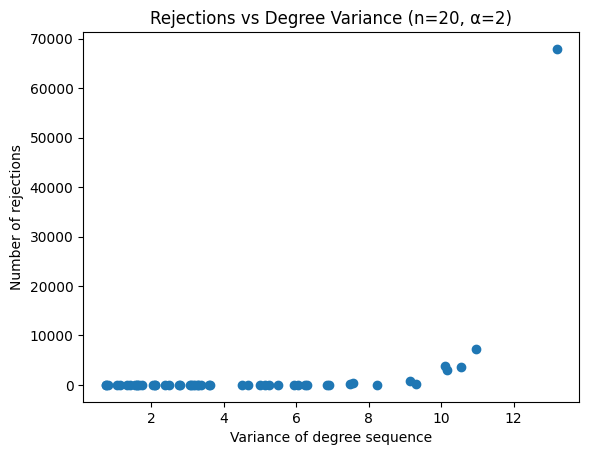

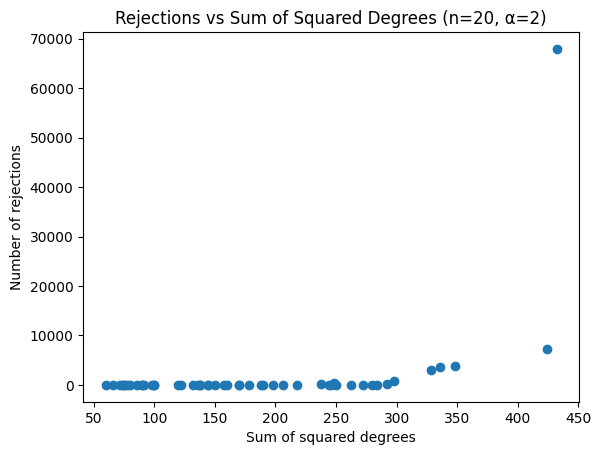

In [ ]:
# Generate data
n = 20
alpha = 2
num_samples = 50

rejections = []
max_deg = []
var_deg = []
sum_sq = []

for _ in range(num_samples):
    seq = power_law_deg_seq(n, alpha)
    _, fails = sample_CM_stub_matching_no_multiple(seq)
    rejections.append(fails)
    max_deg.append(max(seq))
    var_deg.append(np.var(seq))
    sum_sq.append(int((np.array(seq)**2).sum()))

# Compute correlations
corr_max = np.corrcoef(max_deg, rejections)[0,1]
corr_var = np.corrcoef(var_deg, rejections)[0,1]
corr_sq = np.corrcoef(sum_sq, rejections)[0,1]

print(f"Correlation with max degree: {corr_max:.3f}")
print(f"Correlation with variance: {corr_var:.3f}")
print(f"Correlation with sum of squares: {corr_sq:.3f}")

# Plot 1: Variance vs Rejections
plt.figure()
plt.scatter(var_deg, rejections)
plt.xlabel('Variance of degree sequence')
plt.ylabel('Number of rejections')
plt.title('Rejections vs Degree Variance (n=20, α=2)')
plt.show()

# Plot 2: Sum of squared degrees vs Rejections
plt.figure()
plt.scatter(sum_sq, rejections)
plt.xlabel('Sum of squared degrees')
plt.ylabel('Number of rejections')
plt.title('Rejections vs Sum of Squared Degrees (n=20, α=2)')
plt.show()

The results:

1. Max degree vs. rejections (r≈0.36)
2. Variance vs. rejections (r≈0.47)
3. Sum of squares vs. rejections (r≈0.46)

All three correlations are positive, confirming that as any of those statistics increases, you tend to need more rejection attempts. But none of them is extremely high probably because with only 50 random sequences, the precise rank‐ordering of “how bad” one sequence is can shuffle a bit.

We can see that degree‐heterogeneity is the driving force behind rejection difficulty. But max degree matters, only in context of how many other high‑degree stubs are floating around.

## 4 Edge Swapping

### 4.2 Edge Swapping With No Self Edges

Let M(G) be the number of edge-pairs in graph G whose swap would still be simple. Different graphs with the same degree sequence can have different M(G).

In the example from the recitation with degree sequence (1,1,2) there are only 5 legal graphs, but one of them has three times as many legal swaps as another. and the transition diagram in Fig. 3 of the notes visibly assigns it three times the stationary weight.

Because the algorithm always chooses an edge-pair uniformly over the current graph, the probability of leaving a state is proportional to M(G). Detailed balance for the uniform distribution would require:

π(G)P(G→G')=π(G')P(G'→G)

for every adjacent pair G,G'.

with the naive rule P(G→G') = 1/(E choose 2). (a constant) only if both swaps are legal in both directions, which is false once self-loops are forbidden.

To conclude - graphs that admit many legal swaps are oversampled; those with few are undersampled. The chain is still irreducible and aperiodic, so it does converge, but not to the uniform configuration-model ensemble.

Fix suggestion for this problem:

Propose swap as before
If swap illegal → stay put
If swap legal:
     accept with probability   min{1, M(G)/M(G')}

This corrects the imbalance. It slows down moves into graphs that were being oversampled before, and keeps things fair. Over time, every graph ends up with equal chance.

### 4.3 Implementing MCMC in Code

In [4]:
import random, itertools, math, sys

def CM_MCMC(graph_edges, T, rng=None):
    """Edge‑swap MCMC allowing self‑loops and multi‑edges."""
    if rng is None:
        rng = random.Random()
    E = len(graph_edges)
    edges = list(graph_edges)

    for _ in range(T):
        i, j = rng.sample(range(E), 2)
        a, b = edges[i]
        c, d = edges[j]
        edges[i] = (a, d)
        edges[j] = (c, b)
    return edges

# degree sequence k_out = k_in = (1,1,2)
k_seq = [1,1,2]
nodes = range(3)

# build stub lists
out_stubs = [(u, idx) for u, k in enumerate(k_seq) for idx in range(k)]
in_stubs  = [(v, idx) for v, k in enumerate(k_seq) for idx in range(k)]

def canonical(edges):
    return tuple(sorted(edges))

# enumerate all graphs (loops allowed)
all_graphs = set()
for perm in itertools.permutations(in_stubs):
    edges = [ (out_stubs[i][0], perm[i][0]) for i in range(len(out_stubs)) ]
    all_graphs.add(canonical(edges))

all_graphs = list(all_graphs)
g2id = {g:i for i,g in enumerate(all_graphs)}
n_states = len(all_graphs)

print(f"Number of distinct graphs (loops allowed): {n_states}", flush=True)

# MCMC sampling
rng = random.Random(123)
current = list(all_graphs[0])
burn_in = 1000
for _ in range(burn_in):
    current = CM_MCMC(current, 1, rng)

N_samples = 50000
counts = [0]*n_states
steps_between_samples = 5

for step in range(N_samples):
    # advance chain
    for _ in range(steps_between_samples):
        current = CM_MCMC(current, 1, rng)
    counts[g2id[canonical(current)]] += 1

# print frequencies
print("\nState frequencies:")
for gid, cnt in enumerate(counts):
    print(f"  Graph {gid}: {cnt}", flush=True)

expected = N_samples / n_states
chi2 = sum( (cnt-expected)**2/expected for cnt in counts )
df = n_states - 1
print(f"\nChi‑square statistic = {chi2:.2f} with df = {df}", flush=True)



Number of distinct graphs (loops allowed): 7

State frequencies:
  Graph 0: 4138
  Graph 1: 8340
  Graph 2: 8252
  Graph 3: 8487
  Graph 4: 8319
  Graph 5: 4144
  Graph 6: 8320

Chi‑square statistic = 3536.59 with df = 6


There are 7 distinct directed graphs when self-loops are allowed for the degree sequence k=(1,1,2).

After a generous burn-in and 50 000 recorded samples, the two “symmetric” states with many self-loops (IDs 0 and 5 in the listing) are visited only about 4100 times each, while the other five states are hit roughly 8300-8500 times each.

That is exactly what the recitation predicts: the naive edge-swap chain over-represents graphs that possess more legal swap options and under-represents those with fewer.
